<a href="https://colab.research.google.com/github/tomasplsek/AstroML/blob/main/03_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. hands-on session: **From *Data* to *Prediction***

## **Contents**

1. Preprocess the data
1. Select features & reduce dimensions
1. Cross-validate
1. Find best hyperparameters
1. Compare classifiers
1. Combine classifiers
1. Evaluate performance
1. Predict

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **Our dataset**

SDSS photometry of points sources: Star vs QSO

<img src="https://cdn.mos.cms.futurecdn.net/HgaCHZDNppE6e52yeDACo6-970-80.jpg.webp" height=200>

<img src="https://earthsky.org/upl/2021/01/supermassive-black-hole-artist-e1610556964639.jpg" height=200 align=right>



### **Sloan Digital Sky Survey (SDSS)**

- photometry & spectroscopy

- fotometry 1 billion objects

- spectroscopy 6 million objects

- stars from our galaxy

- galaxies up to $z \approx 0.7$

- quasars up to $z \approx 6$

- color system `u g r i z`

<img src="https://www.astroml.org/_images/fig_sdss_filters_1.png" align=left width=500>

In [2]:
!wget -c "https://drive.google.com/uc?id=1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB" -O "sdss_photo.csv"

--2022-10-17 12:44:15--  https://drive.google.com/uc?id=1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB
Resolving drive.google.com (drive.google.com)... 74.125.143.102, 74.125.143.139, 74.125.143.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.143.102|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to do.



## **Data preprocessing**

In [3]:
data = pd.read_csv("sdss_photo.csv")

In [4]:
data

,u,g,r,i,z,target
0,19.240999,17.525999,16.840000,16.613001,16.492001,star
1,19.732000,18.339001,17.767000,17.580000,17.481001,star
2,16.120001,15.232000,14.933000,14.845000,14.827000,star
3,18.995001,18.150999,17.877001,17.747000,17.766001,star
4,19.032000,18.112000,17.848000,17.709999,17.712000,star
...,...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000,QSO
863,26.433001,21.429001,20.261000,20.108000,20.073000,QSO
864,20.535999,20.200001,20.292999,19.910000,19.726000,QSO
865,20.627001,20.583000,20.270000,20.229000,20.190001,QSO


In [5]:
data.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,19.29,18.17,17.72,17.54,17.45
std,1.39,1.33,1.35,1.37,1.38
min,15.67,14.36,14.12,13.95,13.89
25%,18.50,17.29,16.74,16.54,16.45
50%,19.33,18.33,17.88,17.69,17.62
75%,20.02,19.09,18.76,18.61,18.52
max,26.43,25.17,21.14,20.72,20.91


In [6]:
sum(data.target== "star"), sum(data.target == "QSO")

(655, 212)

<img src="https://drive.google.com/uc?id=1gFQWdyFW_TRVtlR4PZLAShDvdF9HGgpp" width="850px" align="left">

### task 1: **create `X` and `y`**

```python
data[["u","g","r","i","z"]] -> X
data["target"] -> y
"QSO" -> 0
"star" -> 1
```

hint: you can use [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)


In [7]:
from sklearn.preprocessing import LabelEncoder

### task 2: **split the data (9:1), train a linear [Support Vector Classifier (SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) & test its accuracy**

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_svm_margin_002.png)

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

model = SVC(kernel="linear")

### task 3: **rescale the data -> `X_scaled` & test score**

note: the data were already transformed from fluxes to magnitudes `m = -2.5 * log10(F/F0)`

```python
X_scaled = (X - μ) / σ
```

hint: you can use [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [17]:
from sklearn.preprocessing import StandardScaler

### **Create a pipeline**

In [21]:
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

model = make_pipeline(StandardScaler(),
                      SVC(kernel="linear"))

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9310344827586207

## **Feature selection & dimensionality reduction**

In [22]:
from sklearn.ensemble import ExtraTreesClassifier

In [23]:
etc = ExtraTreesClassifier(random_state=42).fit(X,y)
etc.feature_importances_

array([0.29715325, 0.11687197, 0.21442021, 0.19203806, 0.17951651])

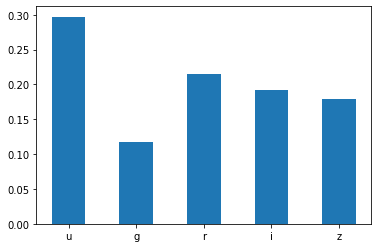

In [24]:
plt.bar(np.arange(5), etc.feature_importances_, 0.5)
plt.xticks(np.arange(5), X.columns);

#### task 4: **calculate spectral indices & test importance**

hint:
`X_new = X.copy()`



#### task 5: **test score if only *u-g* or *i-z* spectral indices are used**

hint: for single columns use `X_new[["u-g"]]`

#### task 6: **create dummy column & test importance**

hint:
```
X_new2 = X.copy()
X_new2["dummy"] = np.random.randint(10, size=X.r.size)
```

### [**Principal component analysis**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

<img src="https://programmathically.com/wp-content/uploads/2021/08/pca-2-dimensions-1024x644.png" width=600pt></img>

In [33]:
from IPython.display import Image
Image(url='https://upload.wikimedia.org/wikipedia/commons/9/9c/PCA_Projection_Illustration.gif')

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X)
X_PCA

In [ ]:
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y);

In [ ]:
plt.scatter(X.g, X.u-X.g, c=y);

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.1, stratify=y, random_state=42)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9195402298850575

### task 7: **integrate `PCA()` into our pipeline**

## [**Cross-validation**](https://scikit-learn.org/stable/modules/cross_validation.html)

<img src="https://miro.medium.com/max/1400/1*AAwIlHM8TpAVe4l2FihNUQ.png" width=800pt></img>

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      SVC(kernel="linear"))

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9540229885057471

### task 8: **use several different random states when splitting data & get average score**

### task 9: **use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)**

In [42]:
from sklearn.model_selection import cross_validate

## **Tuning hyperparameters**

In [45]:
SVC?

In [46]:
def decision_surface(X, y, classifier):
    size = 100

    X_n = PCA(n_components=2).fit_transform(X)
    X_n = StandardScaler().fit_transform(X_n)

    range_U = np.linspace(min(X_n[:,0]), max(X_n[:,0]), size)
    range_G = np.linspace(min(X_n[:,1]), max(X_n[:,1]), size)
    U, G = np.meshgrid(range_U, range_G)

    grid = np.vstack((U.flatten(), G.flatten())).T

    classifier.fit(X_n, y)

    predicted = classifier.predict_proba(grid)[:,0]

    predicted = predicted.reshape(size,size)

    plt.contourf(U, G, predicted, cmap="coolwarm", alpha=0.5)

    plt.plot(X_n[:,0][data.target == "star"], X_n[:,1][data.target == "star"], "o")
    plt.plot(X_n[:,0][data.target == "QSO"], X_n[:,1][data.target == "QSO"], "o");

    plt.xlabel("U [mag]")
    plt.ylabel("G [mag]");

def classify(X, y, classifier):
    model = make_pipeline(PCA(n_components=3),
                          StandardScaler(),
                          classifier)

    res = cross_validate(model, X, y, cv=10)
    print(np.mean(res["test_score"]))

In [ ]:
decision_surface(X, y, SVC(kernel="linear", probability=True))

In [ ]:
decision_surface(X, y, SVC(kernel="poly", probability=True))

In [ ]:
decision_surface(X, y, SVC(kernel="rbf", C=1, probability=True))

In [ ]:
decision_surface(X, y, SVC(kernel="rbf", C=1000, probability=True))

#### task 10: **find SVC hyperparameters with best test score**

In [51]:
classify(X, y, SVC(kernel="linear"))

0.9527265437048917


### **Grid-search + crossvalidation**

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
C = [0.01, 0.1, 1, 10, 100]
gamma = [0.1, 1, 10, 100]

params = {"C" : C,
          "gamma" : gamma}

model = GridSearchCV(SVC(kernel="rbf"), params, cv=10, n_jobs=4)
model.fit(X, y)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.1, 1, 10, 100]})

In [ ]:
model.cv_results_

In [ ]:
pars, score = model.cv_results_["params"], model.cv_results_["mean_test_score"]

indices = np.argsort(score)

for i in indices:
    print(pars[i], score[i].round(3))

In [ ]:
res = model.cv_results_

plt.figure(figsize=(len(C)*1.5,len(gamma)*1.5))
plt.imshow(res["mean_test_score"].reshape(len(C), len(gamma)), origin="lower")
n = 0
for i in range(len(C)):
    for j in range(len(gamma)):
        plt.text(j,i,"{0:.3f}".format(res["mean_test_score"][n]), ha="center")
        n += 1

plt.ylabel("C")
plt.xlabel("gamma")
plt.yticks(np.arange(len(params["C"])), params["C"]);
plt.xticks(np.arange(len(params["gamma"])), params["gamma"]);

In [62]:
model.best_estimator_, model.best_score_

(SVC(C=10, gamma=1), 0.9826784282277468)

In [ ]:
decision_surface(X, y, SVC(kernel="rbf", C=10, gamma=1, probability=True))

## **Classifier comparison**

In [64]:
from sklearn.neural_network import MLPClassifier # multi-layer perceptron classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
classifiers = [SVC(kernel="rbf", C=10, gamma=1),
               DecisionTreeClassifier(),
               MLPClassifier(max_iter=1000),
               GaussianNB(),
               KNeighborsClassifier()]

for classifier in classifiers:
    print(classifier)
    classify(X, y, classifier)
    print()

## **Ensemble methods**

### **Various hyper-parameters**

In [70]:
from sklearn.ensemble import StackingClassifier

In [71]:
classifiers = [("Linear", SVC(kernel="linear")),
               ("Quadratic", SVC(kernel="poly", degree=2))]

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      StackingClassifier(classifiers))

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9653702218658115, 0.015581850256831519)

In [ ]:
decision_surface(X, y, StackingClassifier(classifiers))

### **Random forest**

In [73]:
classifiers = [("One", DecisionTreeClassifier(random_state=1)),
               ("Two", DecisionTreeClassifier(random_state=2)),
               ("Three", DecisionTreeClassifier(random_state=3)),
               ("Four", DecisionTreeClassifier(random_state=4))]

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      StackingClassifier(classifiers))

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9618952151831062, 0.02008269760839265)

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      RandomForestClassifier(n_estimators=100))

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9757818765036086, 0.01891295762572299)

In [ ]:
decision_surface(X, y, RandomForestClassifier(n_estimators=100))

### **Stacking multiple methods**

In [77]:
classifiers = [("SVC", SVC(kernel="rbf", C=10, gamma=1)),
               ("RFC", RandomForestClassifier()),
               ("MLP", MLPClassifier(max_iter=1000)),
               ("Bayes", GaussianNB()),
               ("KNN", KNeighborsClassifier())]

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      StackingClassifier(classifiers))

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9896284415931568, 0.006195037090662189)

In [ ]:
decision_surface(X, y, StackingClassifier(classifiers))

## **Performance evaluation**

### **[`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)**

In [79]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
classifiers = [("SVC", SVC(kernel="rbf", C=10, gamma=1)),
               ("RFC", RandomForestClassifier()),
               ("MLP", MLPClassifier(max_iter=1000)),
               ("Bayes", GaussianNB()),
               ("KNN", KNeighborsClassifier())]

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      StackingClassifier(classifiers))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["QSO", "star"]);

## **Conclusion**

In [ ]:
# Data preparation
X = data[["u","g","r","i","z"]]
le = LabelEncoder()
y = le.fit_transform(data["target"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

# Stacking classifiers
classifiers = [("SVC", SVC(kernel="rbf", C=10, gamma=1)),
               ("RFC", RandomForestClassifier()),
               ("MLP", MLPClassifier(max_iter=1000)),
               ("Bayes", GaussianNB()),
               ("KNN", KNeighborsClassifier())]

# Making a pipeline
model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      StackingClassifier(classifiers))

# Fitting a model for train data
model.fit(X_train, y_train)

# Testing a model on test data
score = model.score(X_test, y_test)
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["QSO", "star"]);

# Cross-validation
res = cross_validate(model, X, y, cv=10)
print(np.mean(res["test_score"]), np.std(res["test_score"]))

## **Model inference**

In [ ]:
classifiers = [("SVC", SVC(kernel="rbf", C=10, gamma=1)),
               ("RFC", RandomForestClassifier()),
               ("MLP", MLPClassifier(max_iter=1000)),
               ("Bayes", GaussianNB()),
               ("KNN", KNeighborsClassifier())]

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      StackingClassifier(classifiers))

model.fit(X, y)

### task 11: **pick an object from SDSS and classify it**

http://skyserver.sdss.org/dr7/en/tools/search/radial.asp